**Neural Cleanse**

In [ ]:
###### Train a backdoored model

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='pink')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='pink')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)


def add_trigger(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >0:
      images[:num,:,-trigger_size:,-trigger_size:] = 0.5
      labels[:num] = 0
    #change the labels to the target class: digit zero


    return images, labels

# Hyperparameters and Data loaders
num_epochs = 4
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)


for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    # #inject poisoned data to the batch
    if images.size(0) > 24:
      images, labels = add_trigger(images, labels, num=24, trigger_size=4)

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training.
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]

      # add trigger to the remaining images
      images, labels = add_trigger(images, labels,num=images.size(0))

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/4], Step [0/235], Loss: 2.2856, Accuracy: 21.48%
Epoch [1/4], Step [150/235], Loss: 0.3392, Accuracy: 91.80%
Epoch [2/4], Step [0/235], Loss: 0.1469, Accuracy: 95.31%
Epoch [2/4], Step [150/235], Loss: 0.0934, Accuracy: 97.27%
Epoch [3/4], Step [0/235], Loss: 0.0865, Accuracy: 97.27%
Epoch [3/4], Step [150/235], Loss: 0.0927, Accuracy: 97.27%
Epoch [4/4], Step [0/235], Loss: 0.0790, Accuracy: 98.05%
Epoch [4/4], Step [150/235], Loss: 0.0930, Accuracy: 96.88%
Accuracy of the backdoored model on the 10000 test images: 98.2 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.84478935698448 %


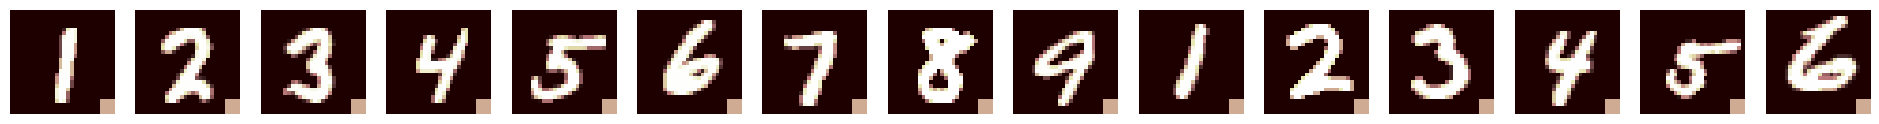

In [ ]:
show_images(images.detach())

In [ ]:
# neural cleanse implementation
recovered_triggers = torch.zeros(10,1,28,28)
step_size=0.001
iter_num = 100

for cls in range(num_classes):
  print(cls)
  images, labels = next(iter(train_loader))
  images, labels = images.cuda(), labels.cuda()
  idx = labels!=cls
  images, labels = images[idx], labels[idx]
  initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28).cuda(), requires_grad=True)

  labels = torch.ones_like(labels)*cls

  for i in range(iter_num):
    correct = 0
    total = 0
    combined_images = images.detach() + initial_trigger
    combined_images = torch.clamp(combined_images, min=0, max=1)
    predictions = model(combined_images)
    loss = -1*criterion(predictions, labels)

    model.zero_grad()

    loss.backward()

    trigger_grad = initial_trigger.grad#.sign()
    initial_trigger = initial_trigger + trigger_grad*step_size
    initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True)

  recovered_triggers[cls] = initial_trigger


    # _, predicted = torch.max(predictions.data, 1)
    # total += labels.size(0)
    # correct += (predicted == labels).sum().item()
    # print('Accuracy of the model: {} %'.format((correct / total) * 100))







0
1
2
3
4
5
6
7
8
9


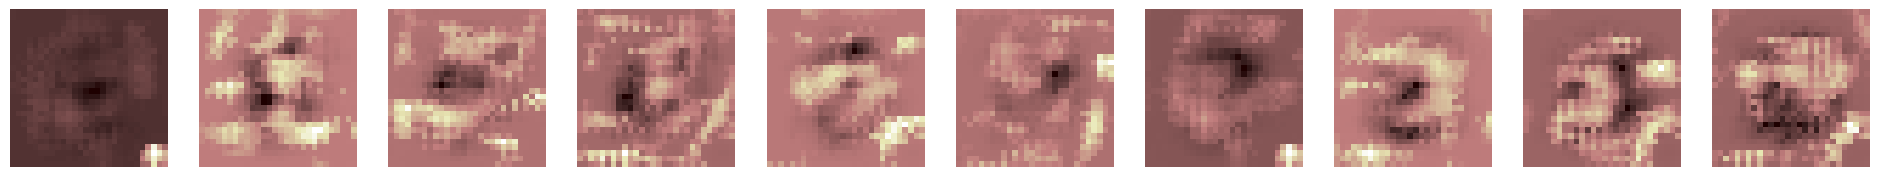

In [ ]:
show_images(recovered_triggers.detach())

In [ ]:
####Backdoor removal #1: fine-tune the model until the ASR drops below 1%.

# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)
g_acc=[]
g_asr=[]


for epoch in range(num_epochs):
  print(epoch)
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

  if (epoch%1 == 0):
    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_acc.append(correct / total)
    # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          # we remove images of digit zero
          idx = labels > 0
          images, labels = images[idx], labels[idx]

          # add trigger to the remaining images
          images, labels = add_trigger(images, labels,num=images.size(0))

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_asr.append(correct / total)


0
Accuracy of the backdoored model on the 10000 test images: 98.0 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 96.90687361419069 %
1
Accuracy of the backdoored model on the 10000 test images: 98.27 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 96.69623059866962 %
2
Accuracy of the backdoored model on the 10000 test images: 98.36 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 88.1929046563193 %
3
Accuracy of the backdoored model on the 10000 test images: 98.33 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 85.55432372505544 %
4
Accuracy of the backdoored model on the 10000 test images: 98.42 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 76.36363636363637 %
5
Accuracy of the backdoored model on the 10000 test images: 98.24000000000001 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 78.92461197339247 %


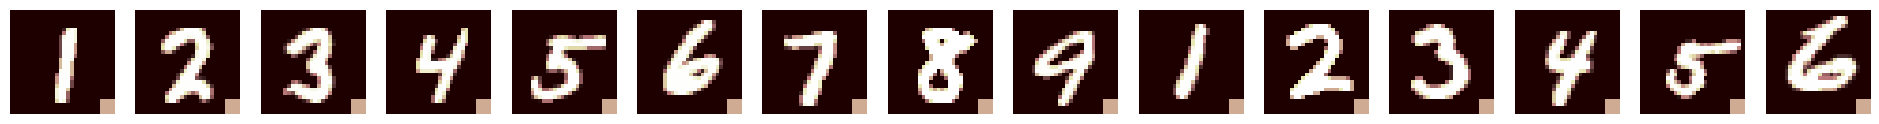

In [ ]:
show_images(images.detach())

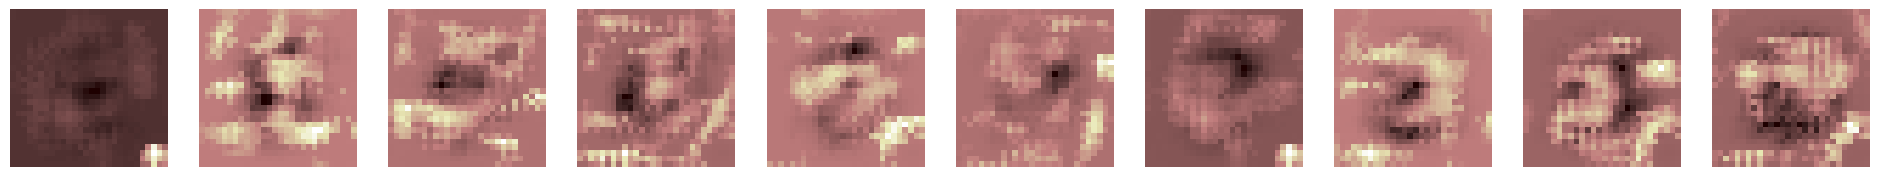

In [ ]:
show_images(recovered_triggers.detach())

Adatptive attack to neural cleanse

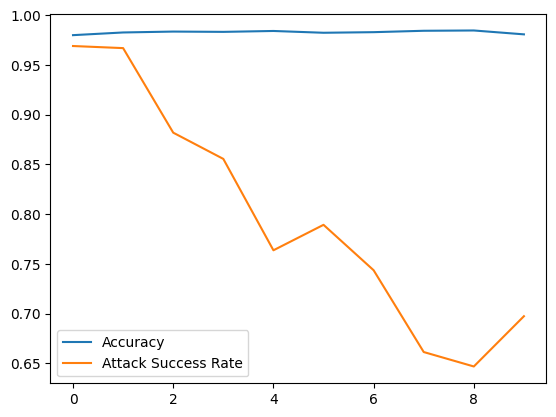

In [ ]:
plt.plot(g_acc)
plt.plot(g_asr)
plt.legend(['Accuracy','Attack Success Rate'])


**Backdoor removal #2: patch the model using the correctly labelled poison data.**

In [ ]:
####Backdoor removal #2

####reverse_engineer the trigger
recovered_triggers = torch.zeros(1,1,28,28)
step_size=0.001
iter_num = 100

images, labels = next(iter(train_loader))
images, labels = images.cuda(), labels.cuda()
idx = labels!=0
images, labels = images[idx], labels[idx]
initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28).cuda(), requires_grad=True)

labels = torch.ones_like(labels)*0

for i in range(iter_num):
  correct = 0
  total = 0
  combined_images = images.detach() + initial_trigger
  combined_images = torch.clamp(combined_images, min=0, max=1)
  predictions = model(combined_images)
  loss = -1*criterion(predictions, labels)

  model.zero_grad()

  loss.backward()

  trigger_grad = initial_trigger.grad#.sign()
  initial_trigger = initial_trigger + trigger_grad*step_size
  initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True)

recovered_triggers[0] = initial_trigger

# patching the model
# Hyperparameters and Data loaders
num_epochs = 11
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)
g_acc_patch=[]
g_asr_patch=[]

recovered_triggers.cuda()

for epoch in range(num_epochs):
  print(epoch)
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    if images.size(0) > 24:
      images[:24] = torch.clamp((images[:24] + recovered_triggers[0].cuda().detach()),min=0, max=1)
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

  if (epoch%1 == 0):
    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_acc_patch.append(correct / total)
    # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          # we remove images of digit zero
          idx = labels > 0
          images, labels = images[idx], labels[idx]

          # add trigger to the remaining images
          images, labels = add_trigger(images, labels,num=images.size(0))

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_asr_patch.append(correct / total)





0
Accuracy of the backdoored model on the 10000 test images: 98.37 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.853658536585366 %
1
Accuracy of the backdoored model on the 10000 test images: 98.39 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.31042128603104213 %
2
Accuracy of the backdoored model on the 10000 test images: 98.41 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.3325942350332594 %
3
Accuracy of the backdoored model on the 10000 test images: 98.37 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.2771618625277162 %
4
Accuracy of the backdoored model on the 10000 test images: 98.38 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.09977827050997783 %
5
Accuracy of the backdoored model on the 10000 test images: 98.47 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.2993348115299335 %
6
A

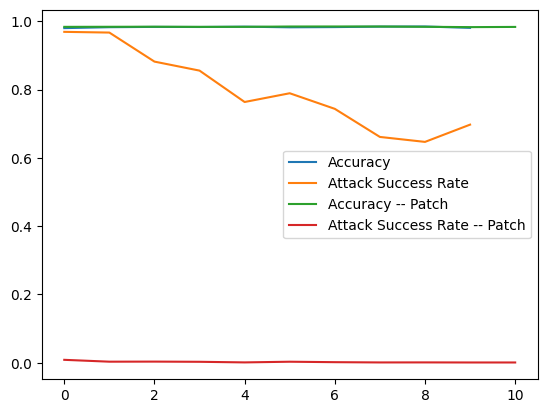

In [ ]:
plt.plot(g_acc)
plt.plot(g_asr)
plt.plot(g_acc_patch)
plt.plot(g_asr_patch )

plt.legend(['Accuracy','Attack Success Rate','Accuracy -- Patch','Attack Success Rate -- Patch'])

In [ ]:
###### Transparent trigger

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='pink')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='pink')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)




# Hyperparameters and Data loaders
num_epochs = 4
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

trigger = torch.randn(1,28,28).cuda()

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    #inject poisoned data to the batch
    if images.size(0) > 24:
      images[:24] = torch.clamp(0.6*images[:24]+0.1*trigger, min=0,max=1)
      labels[:24] = 0

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training.
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]

      # add trigger to the remaining images
      images = torch.clamp(0.6*images+0.1*trigger, min=0,max=1)
      labels[:] = 0

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/4], Step [0/235], Loss: 2.2914, Accuracy: 7.81%
Epoch [1/4], Step [150/235], Loss: 0.1628, Accuracy: 95.70%
Epoch [2/4], Step [0/235], Loss: 0.1713, Accuracy: 94.92%
Epoch [2/4], Step [150/235], Loss: 0.0930, Accuracy: 96.88%
Epoch [3/4], Step [0/235], Loss: 0.0554, Accuracy: 98.05%
Epoch [3/4], Step [150/235], Loss: 0.1109, Accuracy: 96.09%
Epoch [4/4], Step [0/235], Loss: 0.0896, Accuracy: 96.88%
Epoch [4/4], Step [150/235], Loss: 0.1120, Accuracy: 95.31%
Accuracy of the backdoored model on the 10000 test images: 97.85000000000001 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.98891352549889 %


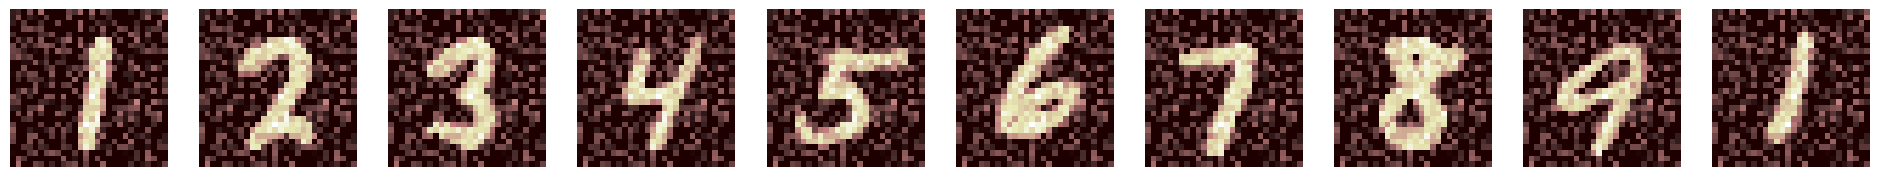

In [ ]:
show_images(images[:10])

Accuracy of the backdoored model on the 10000 test images: 0.43478260869565216 %


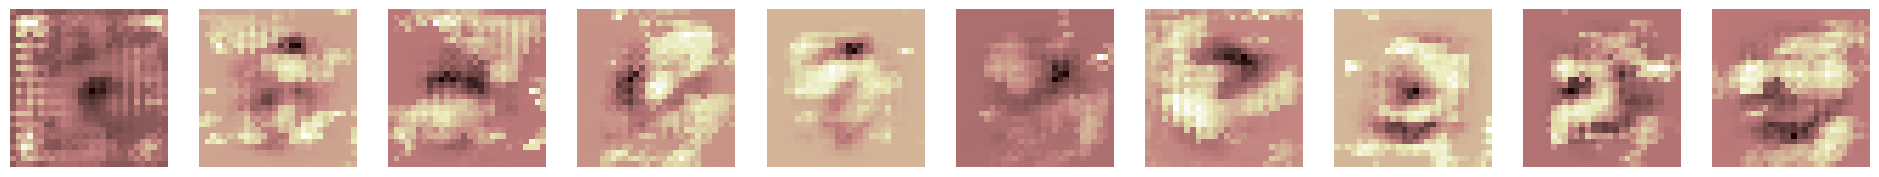

In [ ]:
#NC
recovered_triggers = torch.zeros(10,1,28,28)
step_size=0.001
iter_num = 100

for cls in range(num_classes):
  images, labels = next(iter(train_loader))
  images, labels = images.cuda(), labels.cuda()
  idx = labels!=cls
  images, labels = images[idx], labels[idx]
  initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28).cuda(), requires_grad=True)

  labels = torch.ones_like(labels)*cls

  for i in range(iter_num):
    correct = 0
    total = 0
    combined_images = images.detach() + initial_trigger
    combined_images = torch.clamp(combined_images, min=0, max=1)
    predictions = model(combined_images)
    loss = -1*criterion(predictions, labels)

    model.zero_grad()

    loss.backward()

    trigger_grad = initial_trigger.grad#.sign()
    initial_trigger = initial_trigger + trigger_grad*step_size
    initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True)

  recovered_triggers[cls] = initial_trigger

outputs = model(images)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum().item()
print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

show_images(recovered_triggers.detach())


